# Bussiness Problem

The company Insurance all performed 127.000 with 380.000 customers about their interest in a new auto-insurance product. Their customer will demonstrate or not their interest in purchase the insurance.

    
As a result of our work we will produce a report with our analysis and the answers to the questions below:

   - Principal insights about more relevant attributes to custormers purchase an auto-insurance.
    
   - If the capacity of sales team increases to 40.000 calls, what would be the percetange of the customers interest in acquire an auto-insurance?
  
   - How many calls the sales team need to contact 80% of the customers interested in purchase an auto-insurance?


## Sprints - Schedule

**SPRINT 1 (05/01 - 12/01)**
 
   - Solution Planning (Done);

   - Data Collection (Done);

**SPRINT 2 (12/01 - 19/01)**

   - Descriptive Analysis(Done);

   - Business Research (What is a cross-sell)(Done);

**SPRINT 3 (19/01 - 26/01)**

   - Feature Engineering(DONE);

**SPRINT 4 (26/01 - 02/02)**

   - EDA(Done);

   - Insight Report(Done);


**SPRINT 5 (02/02 - 09/02)**

   - Implementation of Machine Learning Models;

**SPRINT 6 (09/02 - 16/02)**

   - Business Metrics (KPI);

   - Translate to business metrics;

**SPRINT 7 (16/02 - 23/02)**

Deploy of the Model in Production;

**SPRINT 8 (23/02 - 02/03)**

Access of the data in the Model in Production;

**SPRINT 9 (02/03 - 09/03)**

Presentation to Business Team;

**SPRINT 10 (09/03 - 16/03)**

Write an article;
What I Learned;

## Solution Plan

**1. Collect Data.**

   **Tools:**
   
       - SQL(query to retrive data)
       
       - Python(psycopg2, to connect with database)
       
   **Evidence of Completeness:**
   
       - Dataframe in memory with all tables of databaseds.
       
       - A .csv file in disk as backup of the data.

**2. Descriptive Analysis.**
    
   **Tools:**
   
      - Python (pandas)
      
   **Evidence of Completeness:**
   
      Jupyter notebook with:
      
        - Target Balance.
        
        - Descriptive stats for numerical variables(mean, median, mim, max).
        
        - Frequency plots for categorical variables.
        
        - If there is some odd value.
        
        - If there is missing values.
        
        - Presence of outliers.
        
**3. Feature Engineering**
    
   **Tools:**
    
       - Python for Feature Engineering
       - Jupyter notebook for documetation
    
   **Evidence of completeness:**
    
       - Jupyter notebook with the implemetantion of all transformations and Feature Engineering
       
        
**4. EDA / Insight Report.**
    
   **Tools:**
    
       - Draw.io(For mapmind of hypotesis).
       
       - Python(pandas, matplotlib, seaborn).
       
       - Jupyter notebooks.
       
   **Evidence of Completeness:**
    
       - Jupyter notebook with insights between interest, not interest and behavior in data.
 
**5. Data Preparation:**

  **Tools:**
  
       - Python for transformation and preparation to training 
 
  **Evidence of Completeness:**
  
       - Jupyter notebook with the implementations. 
 

**6. Machine Learning Models**

   **Tools:**
    
       - Python as the programing language.
       
       - Pycaret(AutoMl) for auto test several models.
       
       - Keras for develop my first NN.
       
       - Jupyter notebook for documetation.
       
   **Treatment of Data:**  
   
       - From 381k of full data split  230k for training, 76k to validation and 75k to test.
       
       - Validate/tunning the model on validation data (Gain Curve) and test its generalization power on test data. 
      
   **Evidence of completeness:**
    
       - Jupyter notebook with the implemetantions

**7. Business Metrics**
   
   **Tools:**
   
      - Python as a programing language
      - Jupyter notebooks for documentation
   
   **Evidence of completeness:**
   
     Jupyter notebooks
       - % interested customers will be contacted with 20.000 calls;
       - % interested customers will be contacted with 40.000 calls;
   

**8. Deploy the Model**

**9. Presentation**

**10. Article**

## Imports

In [1]:
# System
import os

# Collect and Manipulate data
import psycopg2
import numpy as np
import pandas as pd
import postgres_crud as pc

# Viz\EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

# Hipo Test
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

# Feature Selection
from BorutaShap import BorutaShap

# preprocessing
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler

# ML
import lightgbm as lgb
from pycaret.classification import *
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings("ignore")

## Helper Functions

In [2]:
# Function to select the top null variables
def top_nulls(df, rate):
    null_vars = df.isna().mean().sort_values(ascending=False)
    return null_vars.loc[null_vars>rate].index.to_list()

# Function to convert rs to brl
def convert_rs_to_brl(x, rate):
    return x*rate

# Function to categorize the variable age
def cat_age(x):
    
    if x > 20 and x <= 25 :
        return 'Faixa_20_25'
    elif x > 25 and x <= 30:
        return 'Faixa_25_30'
    else:
        return 'Faixa_maior_30'
    
def Myheat_map(dataset, variaveis):

    df_corr = dataset[variaveis].corr()

    fig, ax = plt.subplots(figsize=(16, 10))
    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
                   linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
                   cbar_kws={"shrink": .8}, square=True)
    yticks = [i.upper() for i in corr.index]
    xticks = [i.upper() for i in corr.columns]
    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks, rotation=20)

    # title
    title = 'CORRELATION MATRIX\n'
    plt.title(title, loc='left', fontsize=18)
    plt.show()
    
def cramer_v(var_x, var_y):

    # builds contigency matrix (or confusion matrix)
    confusion_matrix_v = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix_v.sum()

    # gets the rows, cols
    r, k = confusion_matrix_v.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix_v)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def hipo_test(*samples):

    samples = samples

    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception("Deve ser fornecido pelo menos duas samples!!!")

    if p < 0.05:
        print(f'O valor de p é: {p}')
        print('Provável haver diferença')
    else:
        print(f'O valor de p é: {p}')
        print('Provável que não haja diferença')

    return stat, p

# Coletando os Dados

## Conhecendo as tabelas do BD.

In [5]:
# Parametros
HOST =     ##### 
PORT =     ##### 
DATABASE = ##### 
USERNAME = ##### 
PASSWORD = ##### 

# Query SQL to find the tables names
query =   """
          SELECT table_name 
          FROM information_schema.tables
          WHERE table_schema='pa004'
          AND table_type='BASE TABLE';
          
          """

data = pc.Postgresql.retrieve_data(query=query,
                                   user=USERNAME,
                                   password=PASSWORD,
                                   host=HOST,
                                   port=PORT,
                                   database=DATABASE,
                                   connect=True,
                                   objeto = 'pd')

data

Buscando os dados!!!
Conexão com Postgresql fechada


,table_name
0,users
1,vehicle
2,insurance


Cool we have three tables to work with 'users', 'vehicle', 'insurance'. Let's get them individually.

In [6]:
# querys
query_insurance = """SELECT * FROM pa004.insurance; """
query_users = """SELECT * FROM pa004.users; """
query_vehicle = """SELECT * FROM pa004.vehicle; """

QUERY_LIST = [query_insurance,query_users, query_vehicle]

# Generating a list of dataframes
dataframes = []
for query in QUERY_LIST:
    
    data = pc.Postgresql.retrieve_data(query=query,
                                   user=USERNAME,
                                   password=PASSWORD,
                                   host=HOST,
                                   port=PORT,
                                   database=DATABASE,
                                   connect=True,
                                   objeto = 'pd')
    dataframes.append(data)
    

# Checking duplicated ids
print("\nThere is duplicated ids ?")
for i in range(0,3):
    df = dataframes[i]
    dp = df[['id']].duplicated()
    result = dp.unique()
    print(f'\nDuplicated ids in df {i} - {result}')

Buscando os dados!!!
Conexão com Postgresql fechada
Buscando os dados!!!
Conexão com Postgresql fechada
Buscando os dados!!!
Conexão com Postgresql fechada

There is duplicated ids ?

Duplicated ids in df 0 - [False]

Duplicated ids in df 1 - [False]

Duplicated ids in df 2 - [False]


In [7]:
# Splitting the dataframes in differents DFs.

# Insurance df
insurance_df = dataframes[0]
# Users df
users_df = dataframes[1]
# Vehicle df
vehicles_df = dataframes[2]

# Logical Test - we want a empty set
diff = set(insurance_df['id']).difference(set(users_df['id']), set(vehicles_df['id']))
print(diff)

set()


In [8]:
dataframes[2].head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


## Retriving all data with one Query

In [9]:
# Query SQL to find the tables names
query =   """
            SELECT * 
            FROM pa004.insurance i
            INNER JOIN pa004.users u
                 on i.id = u.id 
            INNER JOIN pa004.vehicle v
                 on u.id = v.id
          """

data = pc.Postgresql.retrieve_data(query=query,
                                   user=USERNAME,
                                   password=PASSWORD,
                                   host=HOST,
                                   port=PORT,
                                   database=DATABASE,
                                   connect=True,
                                   objeto = 'pd')

data.head()

Buscando os dados!!!
Conexão com Postgresql fechada


,id,previously_insured,annual_premium,vintage,response,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes
1,13,1,31409.0,221,0,13,Female,41,15.0,14.0,13,1,1-2 Year,No
2,18,1,46622.0,299,0,18,Female,25,35.0,152.0,18,1,< 1 Year,No
3,31,0,2630.0,136,0,31,Female,26,8.0,160.0,31,1,< 1 Year,No
4,39,0,42297.0,264,0,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes


In [10]:
# Saving the data in disk, this way we dont need to send unnecessary requests to our database.
data.to_csv('data/full_database.csv')

# Data Description

## Variable Index

**id:**                      Unique ID for the customer

**Gender:** 	             Gender of the customer

**Age:** 	                 Age of the customer

**Driving_License:** 	     0 : Customer does not have DL, 1 : Customer already has DL

**Region_Code:** 	         Unique code for the region of the customer

**Previously_Insured:** 	 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

**Vehicle_Age:** 	         Age of the Vehicle

**Vehicle_Damage:** 	     1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

**Annual_Premium:** 	     The amount customer needs to pay as premium in the year   **- Values in Rs(Indian Rupee)**

**PolicySalesChannel:** 	 Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage:**	             Number of Days, Customer has been associated with the company

**Response:**                1 : Customer is interested, 0 : Customer is not interested

## Collecting data from Disk

In [3]:
# Collecting the data from disk.
data = pd.read_csv('data/full_database.csv')

# Dropping redudant columns.
data.drop(['Unnamed: 0','id.1','id.2'], inplace=True, axis=1)

In [4]:
data.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes


## General Describe of Data. 

In [5]:
# Describe
pd.DataFrame({'missing' :data.isna().mean(),
              'uniques' :data.nunique(),
              'dtypes'  :data.dtypes,
              'min'     :data.min(),
              'mean'    :data.mean(),
              'median'  :data.median(),
              'max'     :data.max(),
              'skew'    :data.skew(),
              'kurtosis':data.kurtosis()})

,missing,uniques,dtypes,min,mean,median,max,skew,kurtosis
age,0.0,66,int64,20,38.822584,36.0,85,6.725390e-01,-0.565655
annual_premium,0.0,48838,float64,2630.0,30564.389581,31669.0,540165.0,1.766087e+00,34.004569
driving_license,0.0,2,int64,0,0.997869,1.0,1,-2.159518e+01,464.354302
gender,0.0,2,object,Female,NaN,NaN,Male,NaN,NaN
id,0.0,381109,int64,1,190555.000000,190555.0,381109,-8.071174e-18,-1.200000
policy_sales_channel,0.0,155,float64,1.0,112.034295,133.0,163.0,-9.000081e-01,-0.970810
previously_insured,0.0,2,int64,0,0.458210,0.0,1,1.677471e-01,-1.971871
region_code,0.0,53,float64,0.0,26.388807,28.0,52.0,-1.152664e-01,-0.867857
response,0.0,2,int64,0,0.122563,0.0,1,2.301906e+00,3.298788
vehicle_age,0.0,3,object,1-2 Year,NaN,NaN,> 2 Years,NaN,NaN


 - We have no missing value.
 - annual_premium, policy_sales_channel, region_code, vintage has diferent scales min: 2630.0  max: 540165.0.
 - driving_license, previously_insured, vehicle_age, vehicle_damage, previously_insured is categorical feature and not int64.
 - the annual_premium has large values for brazillian standarts we will convert it from Rs (Indian Rupee) to BRL (Brazilliam Real)
 - response is our Target variable.
 - id is our unique feature.

## Changing dtypes of our dataset

In [6]:
# Category variabels
variables = ['driving_license',
             'region_code',
             'policy_sales_channel',
             'previously_insured', 
             'vehicle_age', 
             'vehicle_damage', 
             'previously_insured', 
             'gender',
             'response']

for var in variables:
    data[var] = data[var].astype('category')

## Target - response

response
0    87.743664
1    12.256336
Name: id, dtype: float64

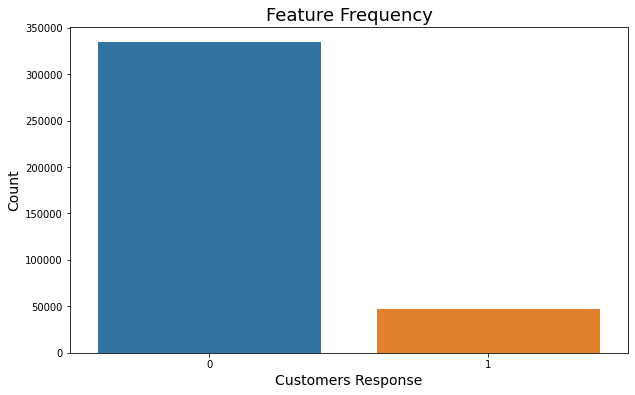

In [10]:
# Checkando o balanciamento da variável Target
ax = sns.countplot(x='response', hue=None, data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Customers Response', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

# Percentual de observações por valores Geography
data.groupby('response').count()['id'].apply(lambda x: (x/data.shape[0])*100)

- We have an unbalanced target with 87.74% to not interested and 12.25% to interest in purchase the insurance.

## Gender vs Response

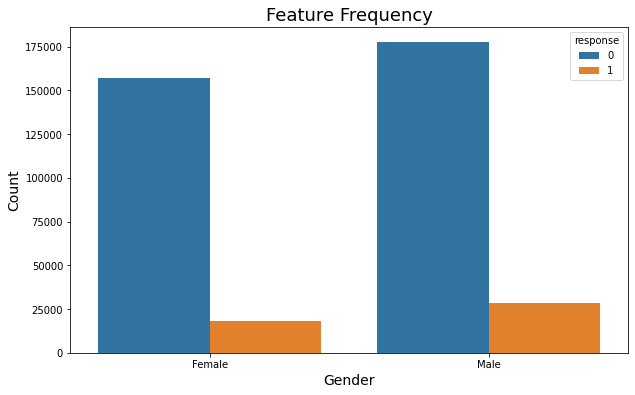

In [11]:
ax = sns.countplot(x='gender', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [12]:
# Porcentage of observations by Gender
data.groupby('gender').count()['id'].apply(lambda x: (x/data.shape[0])*100)

gender
Female    45.92387
Male      54.07613
Name: id, dtype: float64

- We cant find a concentration of the positive event by gender. With the majority of males

## driving_license vs response

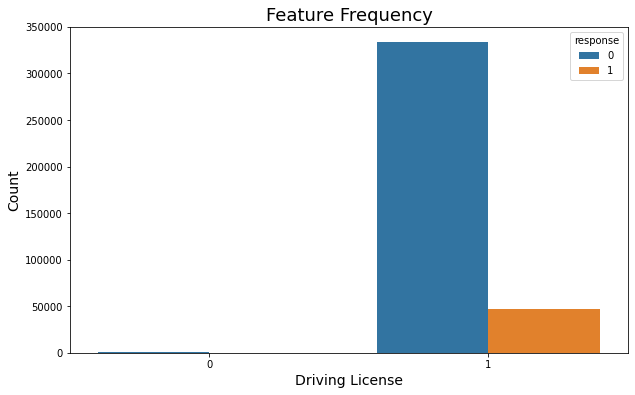

In [13]:
ax = sns.countplot(x='driving_license', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Driving License', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [14]:
# Porcentage of observations by driving_license
data.groupby('driving_license').count()['id'].apply(lambda x: (x/data.shape[0])*100)

driving_license
0     0.213062
1    99.786938
Name: id, dtype: float64

- We can see that the majority of our customers has driving license.

## previously_insured vs response

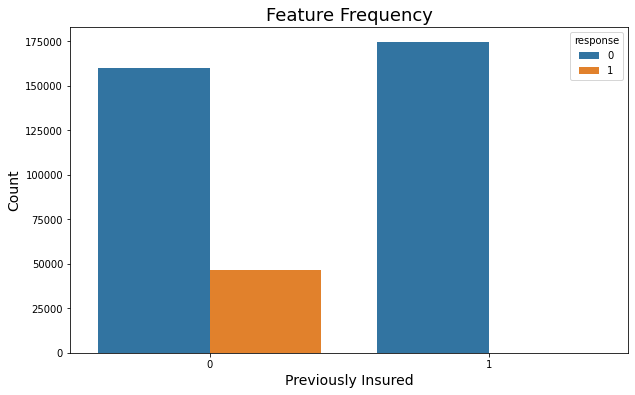

In [62]:
ax = sns.countplot(x='previously_insured', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Previously Insured', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

In [15]:
# Porcentage of observations by previously_insured
data.groupby('previously_insured').count()['id'].apply(lambda x: (x/data.shape[0])*100)

previously_insured
0    54.178988
1    45.821012
Name: id, dtype: float64

- We can see that the interest in purchase a insurance is higher when you dont have a previously insured.

## vehicle_age vs response

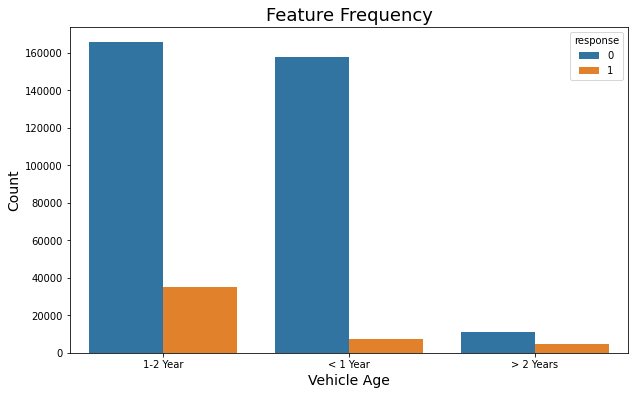

In [63]:
ax = sns.countplot(x='vehicle_age', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Vehicle Age', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

- Strong concentration of interest with owner between 1 and 2 years also its the majority in the 1-2 Year category.

In [69]:
# Porcentage of observations by previously_insured
data.groupby('vehicle_age').count()['id'].apply(lambda x: (x/data.shape[0])*100)

vehicle_age
1-2 Year     52.561341
< 1 Year     43.238549
> 2 Years     4.200111
Name: id, dtype: float64

## vehicle_damage vs response

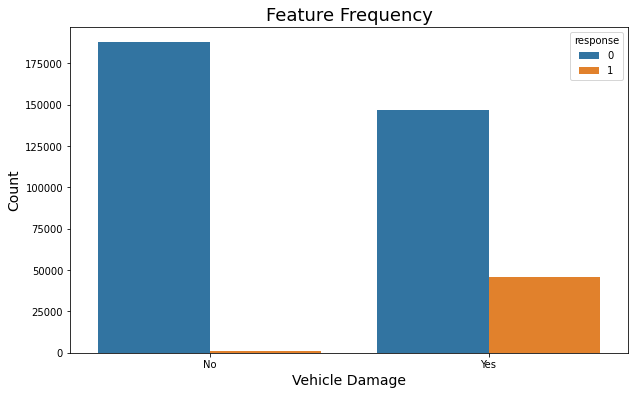

In [16]:
ax = sns.countplot(x='vehicle_damage', hue='response', data=data)
ax.figure.set_size_inches(10, 6)
ax.set_title('Feature Frequency', fontsize=18, loc='center')
ax.set_xlabel('Vehicle Damage', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax=ax

- Strong concentration of interest with owners of damaged vehicle.

In [17]:
# Porcentage of observations by previously_insured
data.groupby('vehicle_damage').count()['id'].apply(lambda x: (x/data.shape[0])*100)

vehicle_damage
No     49.512344
Yes    50.487656
Name: id, dtype: float64

## Cheking the presense of outliers

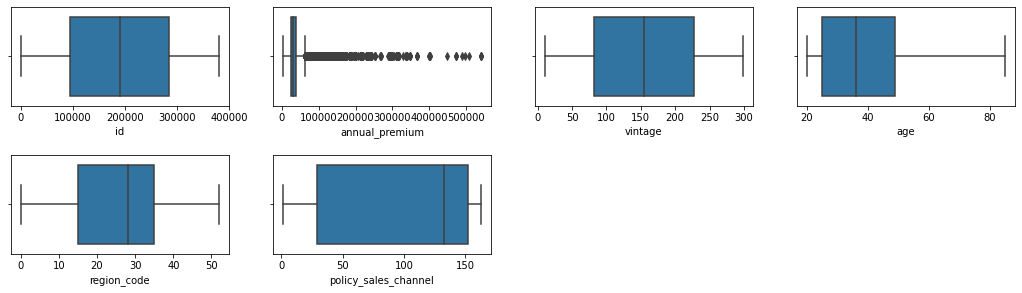

In [18]:
# Variáveis
variables = data.select_dtypes(['int64', 'float64']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(18, 10))
for column in data[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.boxplot(x=column, data=data)
    n += 1

plt.subplots_adjust(hspace=0.5)
plt.show()

- We can observe outliers at annual_premimum.

### annual_premium

In [19]:
# Calculando o Q1 e Q3 e IQR
Q1 = np.quantile(data['annual_premium'], .25)
Q3 = np.quantile(data['annual_premium'], .75)
IQR = Q3 - Q1

# Calculando os limites low and high
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

# priting the limits
print(f'Low Limit is {low}')
print(f'High Limit is {high}')

Low Limit is 1912.5
High Limit is 61892.5


# Feature Engineering

## Converting the annual premium

In [6]:
# Exchabge Rate - BRL X Rs = 0.07490
data['annual_premium_brl'] = data['annual_premium'].apply(lambda x: convert_rs_to_brl(x, rate=0.07490))

In [7]:
# Annual_premium_brl created - We will use annual_premium_brl
data.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,annual_premium_brl
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes,1750.1883
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No,2352.5341
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No,3491.9878
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No,196.9870
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes,3168.0453


## annual_premium_brl squared

In [8]:
data['annual_premium_brl_squared'] = data['annual_premium_brl'].apply(lambda x: x**2)
data.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,annual_premium_brl,annual_premium_brl_squared
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes,1750.1883,3.063159e+06
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No,2352.5341,5.534417e+06
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No,3491.9878,1.219398e+07
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No,196.9870,3.880388e+04
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes,3168.0453,1.003651e+07


## annual_premium_brl divided by vintage

In [9]:
data['annual_premium/vintage'] = data['annual_premium_brl']/data['vintage']
data.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,annual_premium_brl,annual_premium_brl_squared,annual_premium/vintage
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes,1750.1883,3.063159e+06,7.028869
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No,2352.5341,5.534417e+06,10.644951
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No,3491.9878,1.219398e+07,11.678889
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No,196.9870,3.880388e+04,1.448434
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes,3168.0453,1.003651e+07,12.000172


## Age Categorical

In [10]:
data['cat_age'] = data['age'].apply(lambda x: cat_age(x))
data.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,annual_premium_brl,annual_premium_brl_squared,annual_premium/vintage,cat_age
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes,1750.1883,3.063159e+06,7.028869,Faixa_20_25
1,13,1,31409.0,221,0,Female,41,15.0,14.0,1,1-2 Year,No,2352.5341,5.534417e+06,10.644951,Faixa_maior_30
2,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No,3491.9878,1.219398e+07,11.678889,Faixa_20_25
3,31,0,2630.0,136,0,Female,26,8.0,160.0,1,< 1 Year,No,196.9870,3.880388e+04,1.448434,Faixa_25_30
4,39,0,42297.0,264,0,Male,45,8.0,124.0,1,1-2 Year,Yes,3168.0453,1.003651e+07,12.000172,Faixa_maior_30


## Median by policy_sales_channel

In [11]:
dados_temp = data.groupby('policy_sales_channel')['annual_premium_brl'].median()
dados_temp = pd.DataFrame(dados_temp)

In [12]:
data = data.merge(dados_temp, on='policy_sales_channel')
data.rename(columns={'annual_premium_brl_y': 'median_by_policy',
                     'annual_premium_brl_x':'annual_premium_brl'}, inplace=True)

In [13]:
data.head()

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,annual_premium_brl,annual_premium_brl_squared,annual_premium/vintage,cat_age,median_by_policy
0,7,0,23367.0,249,0,Male,23,11.0,152.0,1,< 1 Year,Yes,1750.1883,3.063159e+06,7.028869,Faixa_20_25,2303.6244
1,18,1,46622.0,299,0,Female,25,35.0,152.0,1,< 1 Year,No,3491.9878,1.219398e+07,11.678889,Faixa_20_25,2303.6244
2,73,1,40372.0,242,0,Female,23,39.0,152.0,1,< 1 Year,No,3023.8628,9.143746e+06,12.495301,Faixa_20_25,2303.6244
3,95,0,41641.0,209,0,Female,23,15.0,152.0,1,< 1 Year,Yes,3118.9109,9.727605e+06,14.923019,Faixa_20_25,2303.6244
4,120,0,2630.0,149,0,Female,23,25.0,152.0,1,< 1 Year,No,196.9870,3.880388e+04,1.322060,Faixa_20_25,2303.6244


# EDA

## Univariate Analysis

### Variáveis Categoricas

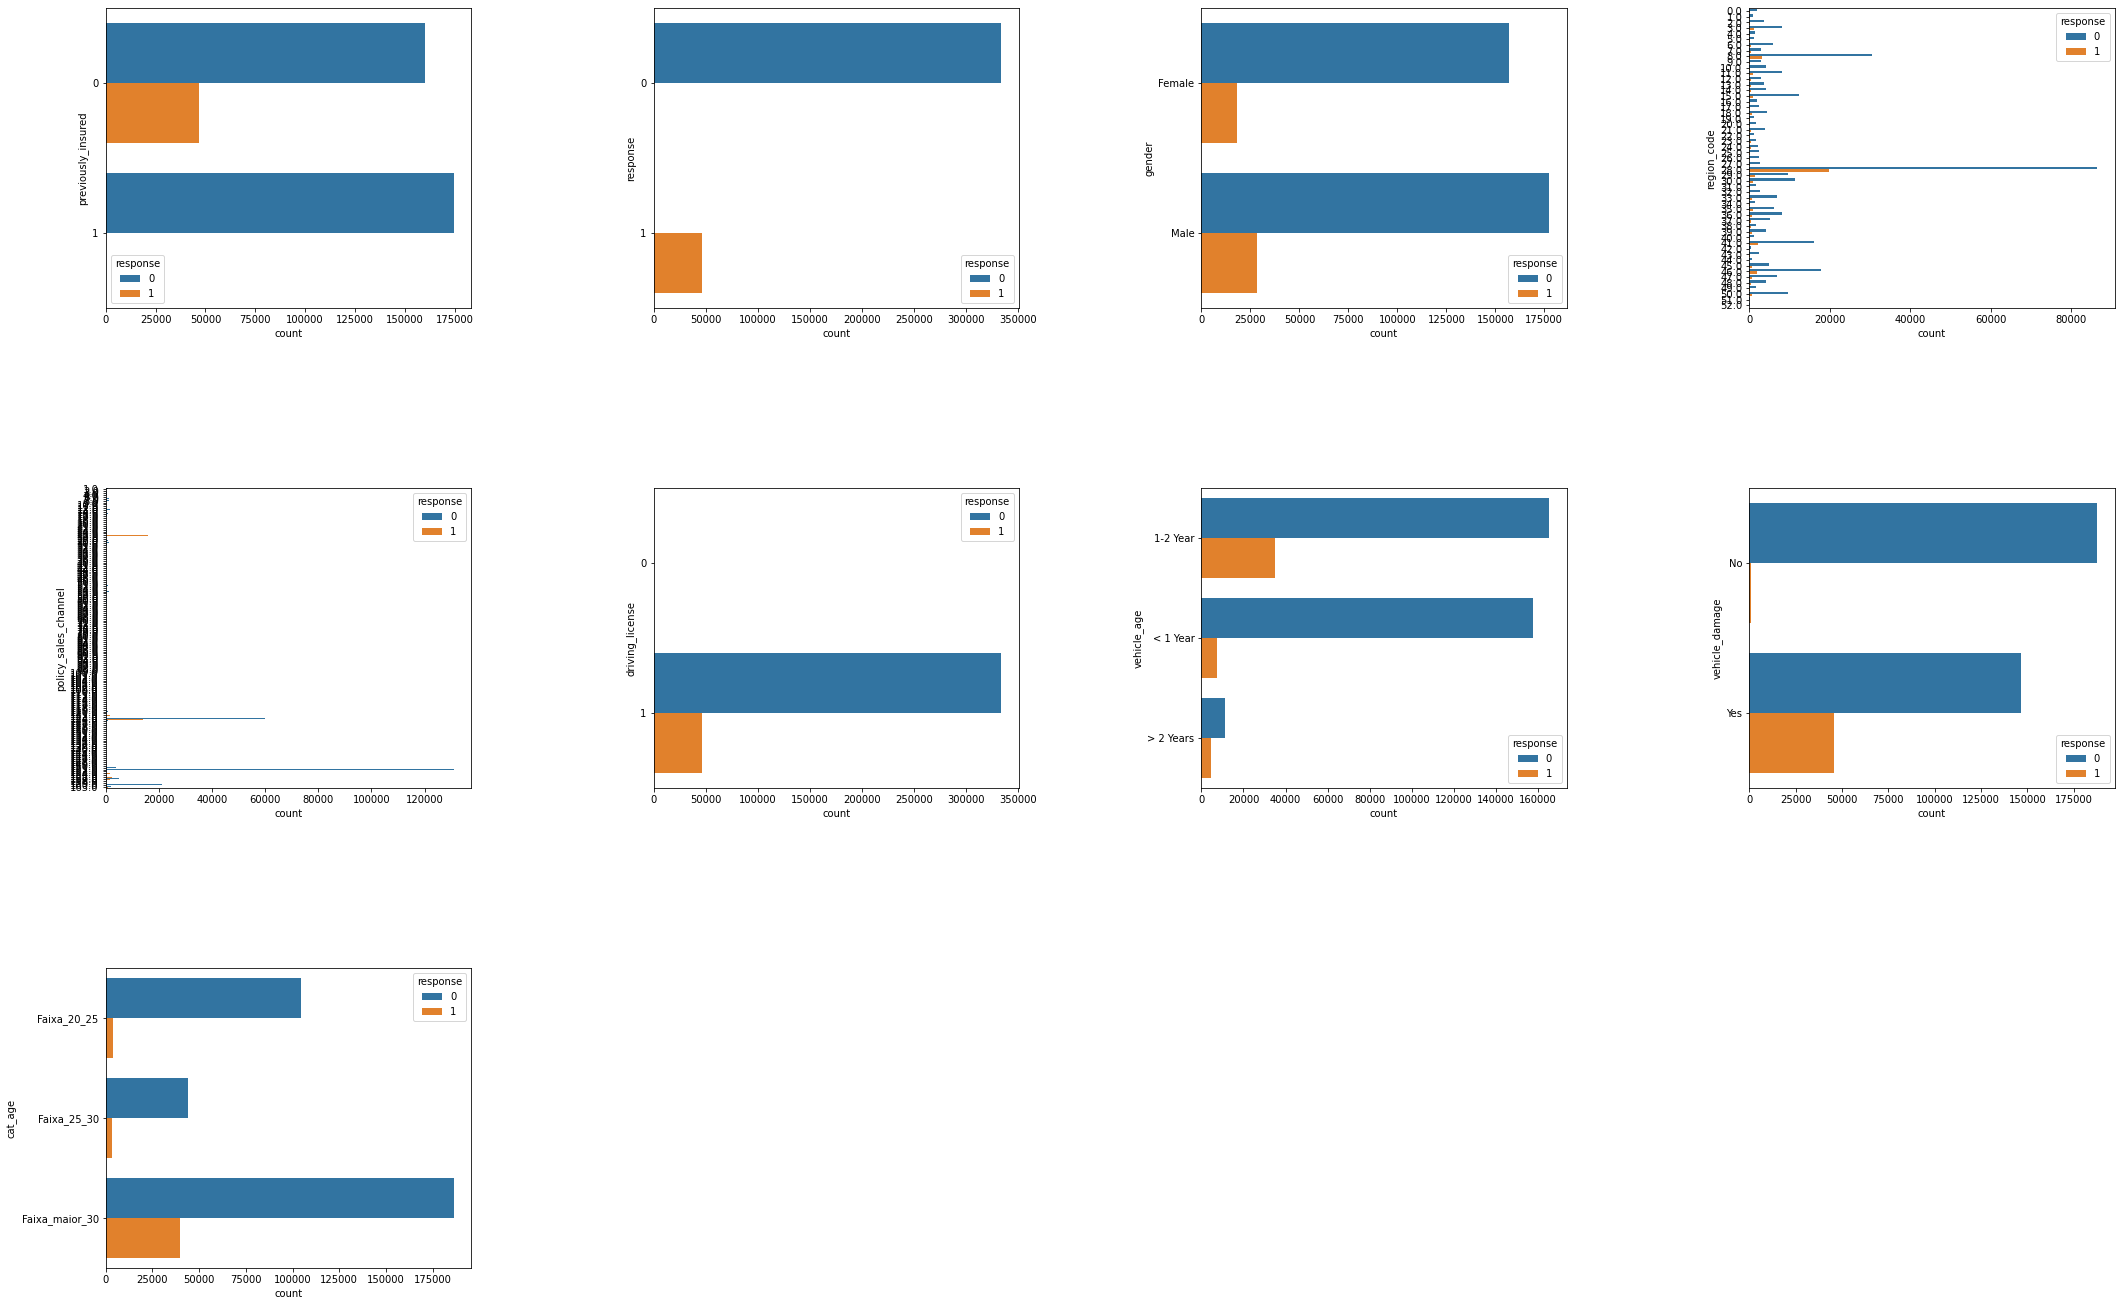

In [17]:
# checking the outliers again.
# Variáveis
variables = data.select_dtypes(['category', 'object']).columns.to_list()

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in data[variables].columns:
    plt.subplot(4, 4, n)
    _ = sns.countplot(y=column,hue='response', data=data)
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

- We can basically see the same points highlighted in descriptive analysis section
- We also can see that policy_sales_channel and region_code have a lot categorys but with some of them getting a high frequency.

Bellow the Top 5 categorys of region_code and policy_sales_channel we can see the main regions and channels of our customers.

In [43]:
# Top region_code
region_code = data.groupby('region_code').count()['id']
region_code.sort_values(ascending=False).head()

region_code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
Name: id, dtype: int64

In [44]:
# Top policy_sales_channel
policy_sales = data.groupby('policy_sales_channel').count()['id']
policy_sales.sort_values(ascending=False).head()

policy_sales_channel
152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
Name: id, dtype: int64

### Variáveis Númericas

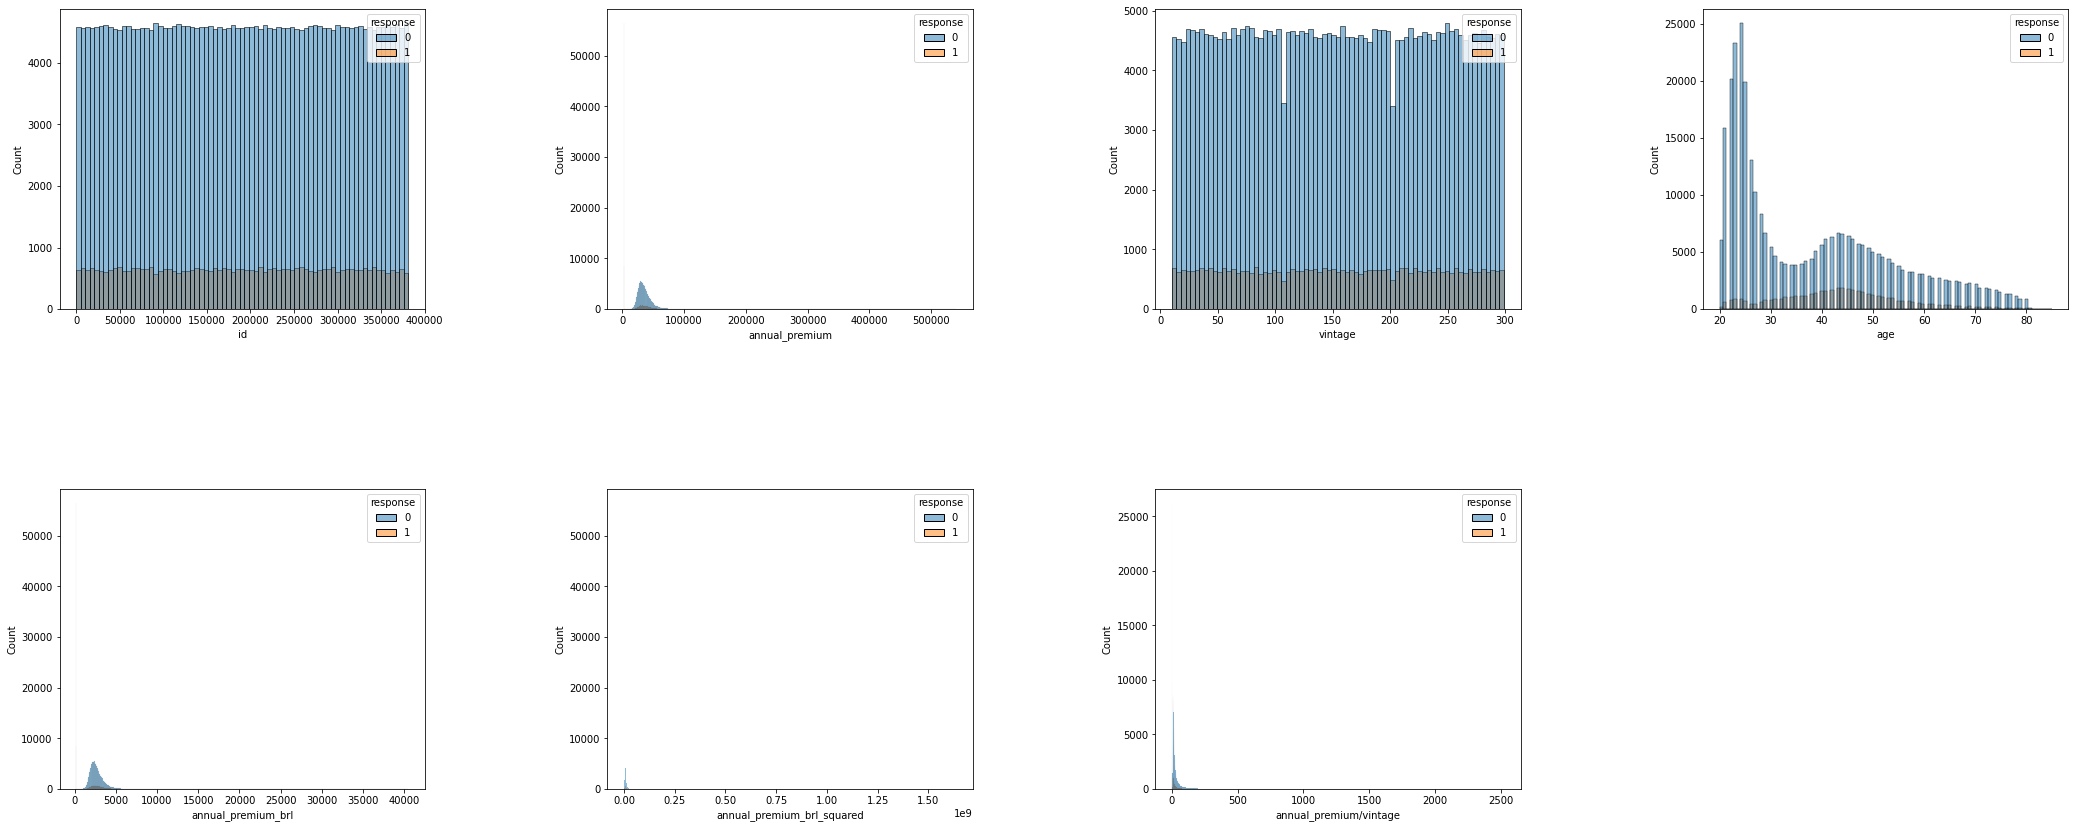

In [18]:
# Antes do feature eng
variables = data.select_dtypes(['int64','float64']).columns.to_list()
#variables.remove('RowNumber'), variables.remove('CustomerId')

# Setando a posicão inicial
n = 1

plt.figure(figsize=(36, 32))
for column in data[variables].columns[:len(variables)-1]:
    plt.subplot(4, 4, n)
    _ = sns.histplot(data = data, x=column, hue='response')
    n += 1

plt.subplots_adjust(hspace=0.6,wspace=0.5)
plt.show()

 - Its seems that there is a incresing in the interst with the age
 - We can see that with annual_premium and the annual_premium related variables we have the presence of outliers

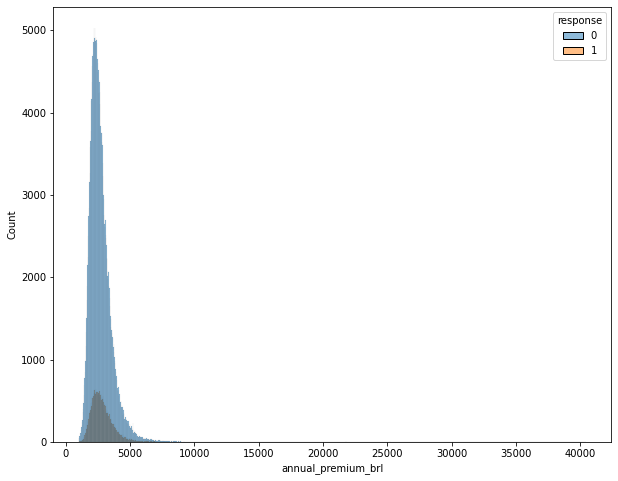

In [20]:
# annual_premium_brl
data_temp = data.loc[data['annual_premium_brl']>1000,['annual_premium_brl','response']]

plt.figure(figsize=(10, 8))
sns.histplot(data = data_temp, x='annual_premium_brl', hue='response')
plt.show()

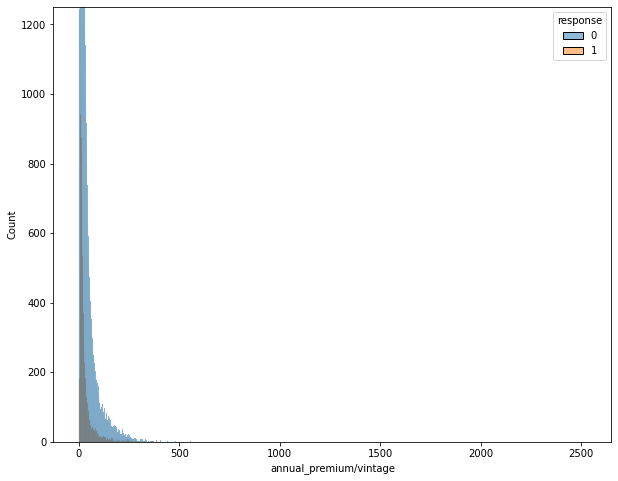

In [54]:
# annual_premium/vintage
data_temp = data.loc[:,['annual_premium/vintage','response']]

plt.figure(figsize=(10, 8))
sns.histplot(data = data_temp, x='annual_premium/vintage', hue='response')
plt.ylim(0,1250)
plt.show()

## Multivariate Analysis

CPU times: user 9min 25s, sys: 30.5 s, total: 9min 55s
Wall time: 9min 17s


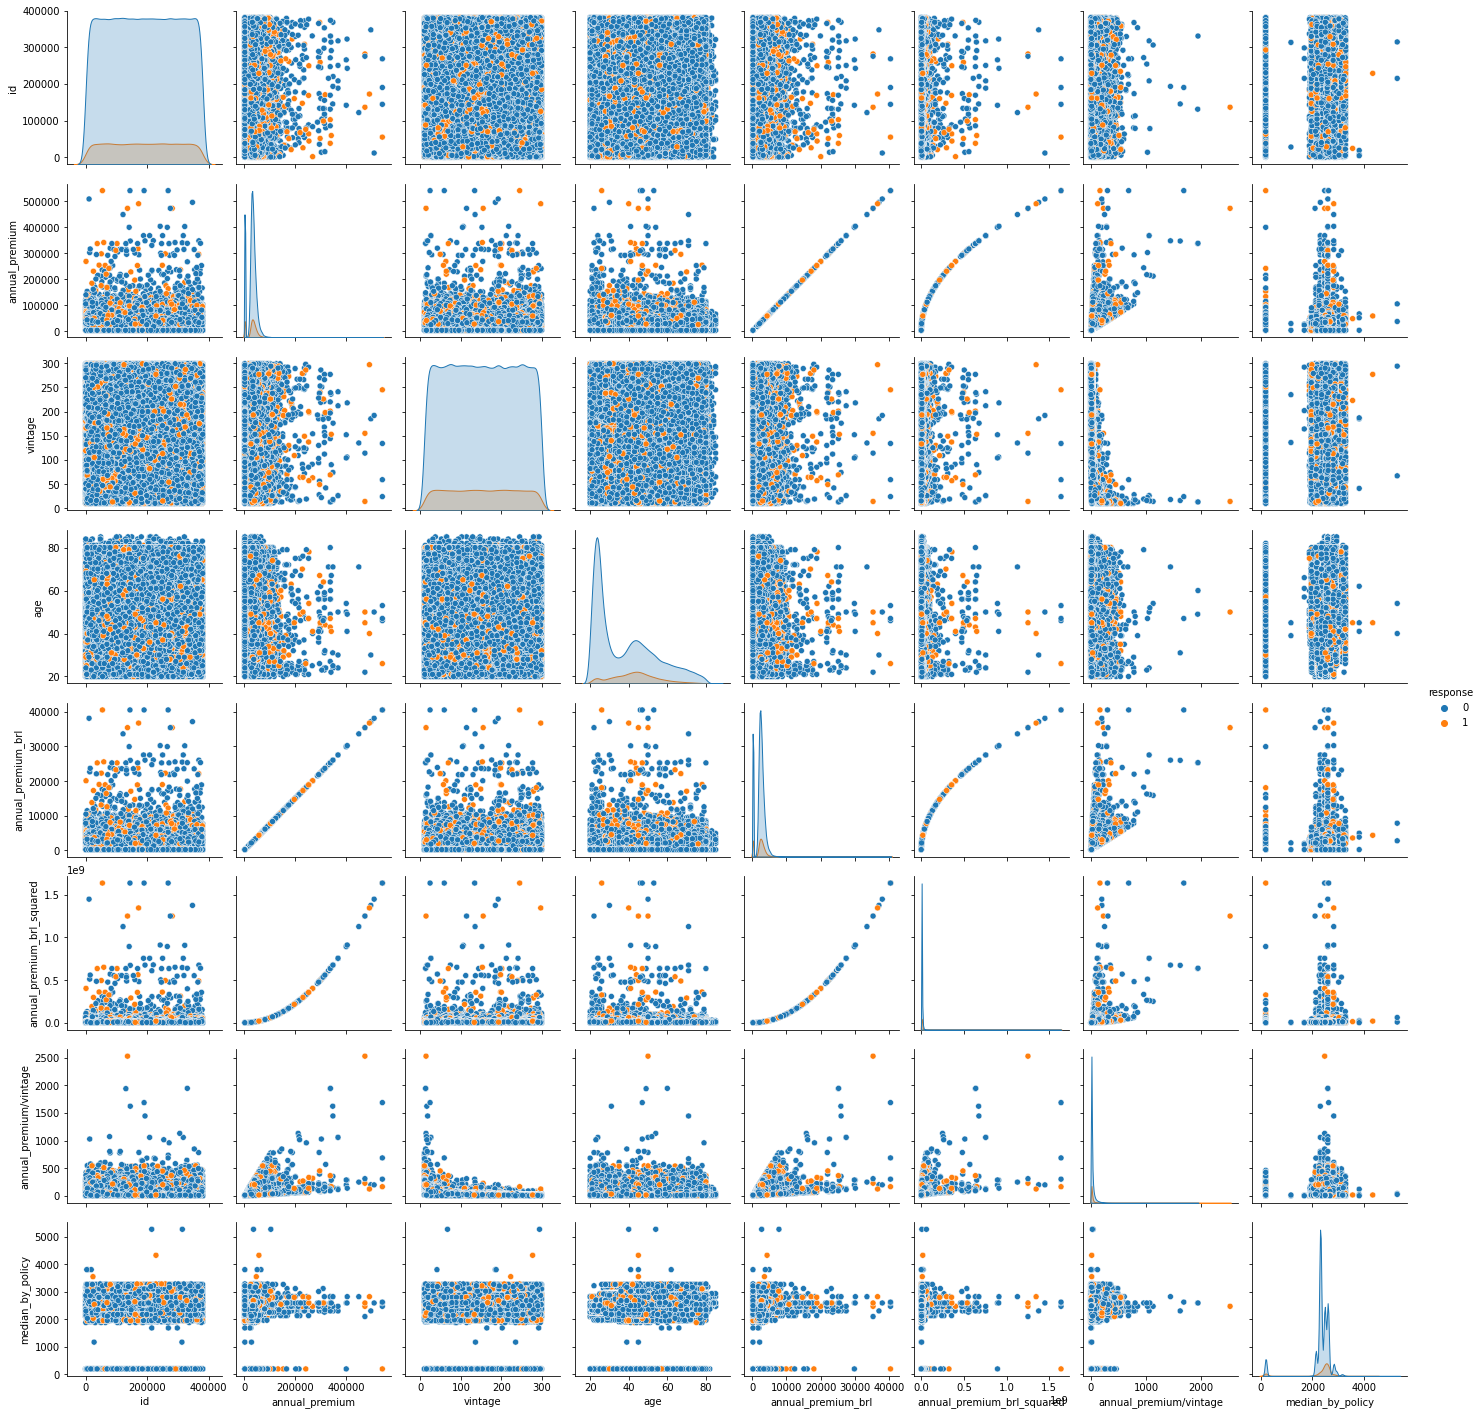

In [21]:
%%time
# Variáveis
variables = data.select_dtypes(['int64','float64']).columns.to_list()
variables.append('response')

sns.pairplot(data[variables], hue='response')

## Correlations

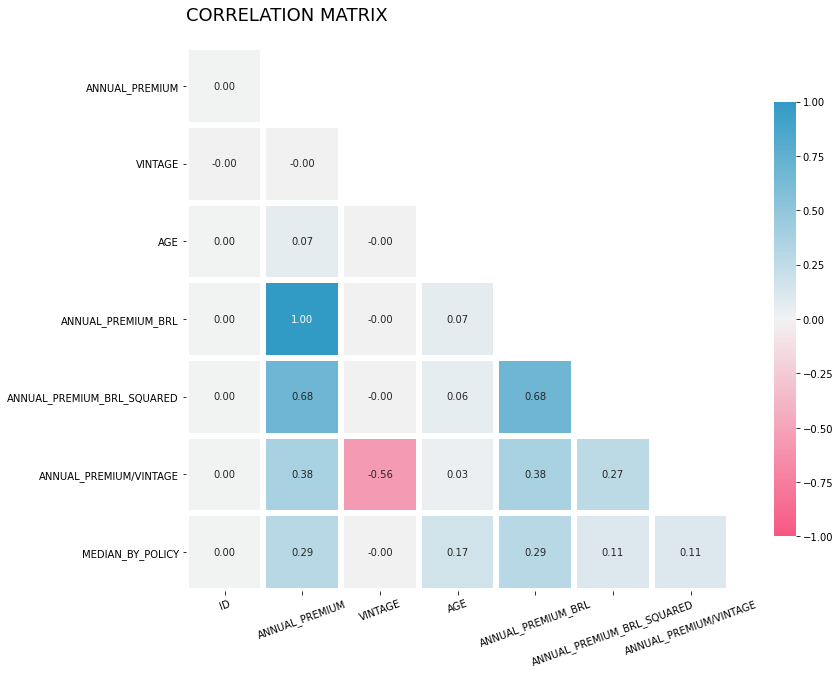

In [22]:
Myheat_map(dataset=data, variaveis=variables  )

- As expected annual_premium_brl_squared is well related with annual_premium_brl but its not over 0.70 so we will let to Boruta decide with we keep this variable

- We will drop annual_premium and ID variables.

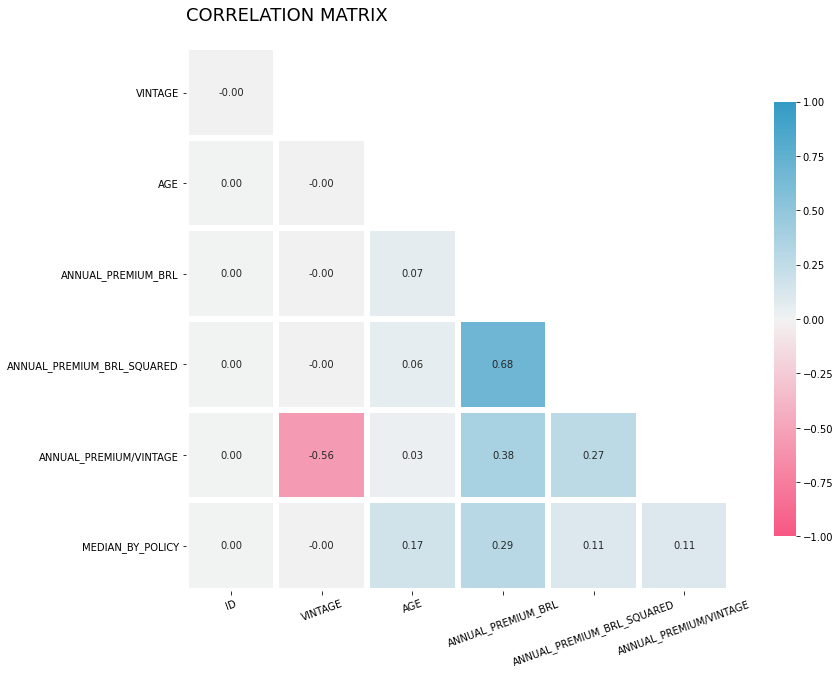

In [55]:
# Removendo variáveis com grande correlação
new_variables = variables.copy()
var_list = ['annual_premium', 'id']

for var in var_list:
    new_variables.remove(var)
Myheat_map(dataset=data, variaveis=new_variables)

Text(0.5, 1.0, 'Pointbiserialr')

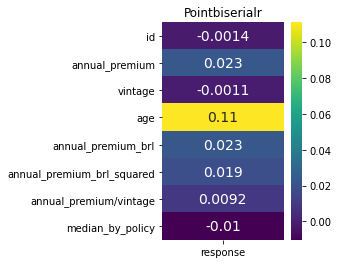

In [31]:
# Numericas com relação a target
variables = data.select_dtypes(['int64','float64']).columns.to_list()

# Correlações
corrs = [pointbiserialr(data['response'], data[var])[0] for var in variables]
df_corr = pd.DataFrame({'response': corrs}, index=variables)

# Plot Matrix
fig, ax = plt.subplots()
plt.subplot(1, 2, 1)
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Pointbiserialr")

 - We dont have any variable with a high correlation with our Target variable.

## Categorical Variables - cramers v

Text(0.5, 1.0, 'Cramér V')

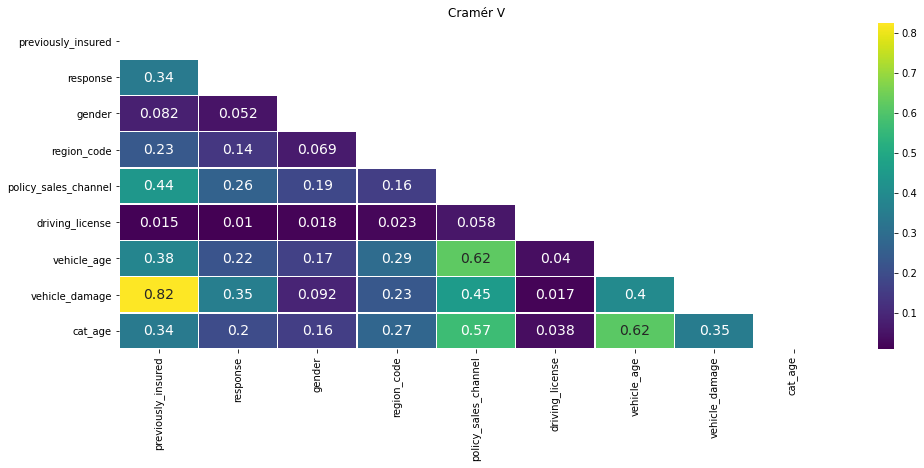

In [38]:
# colunas
cols = data.select_dtypes(['category', 'object']).columns.to_list()

# Dicionário para registro das correlações
dictt = {
        'previously_insured': [],
        'response': [],
        'gender': [],
        'region_code': [],
        'policy_sales_channel' : [],
        'driving_license': [],
        'vehicle_age': [],
        'vehicle_damage': [],
        'cat_age': [] 
        }

for col in cols:
    for col1 in cols:
        corr = cramer_v(data[col], data[col1])
        dictt[col].append(corr)
        
# Matriz de Correlação
df_cramer1 = pd.DataFrame(dictt)
df_cramer1 = df_cramer1.set_index(df_cramer1.columns)

# HeatMap
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 6)

mask = np.triu(np.ones_like(df_cramer1, dtype=np.bool))
sns.heatmap(df_cramer1, mask=mask, linewidths=.5, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Cramér V")

- We can see a strong correlation between vehicle_damage and previously_insured.
- We will if Boruta algorithm keeps them and experiment dropping one of them as well.

# Insights Report

In [ ]:
# Is the interest diferent by gender?
# Is the annual_premium value diferent by gender?
# Is the annual_premium value diferente by age and the interest?
# Vehicle being damage before changes the annual_premium and the interest? 
# Is the annual_premium value diferente by vehicle_age and the interest?

## Is the interest diferent by gender?

In [28]:
# Percentual of the interest customers by gender
gender_temp = data.groupby('gender')['response'].sum()/data.loc[data['response']==1,:].shape[0]
gender_temp

gender
Female    0.389317
Male      0.610683
Name: response, dtype: float64

- Looks like there is more interest by Male Customers

## Is the annual_premium value diferent by gender?

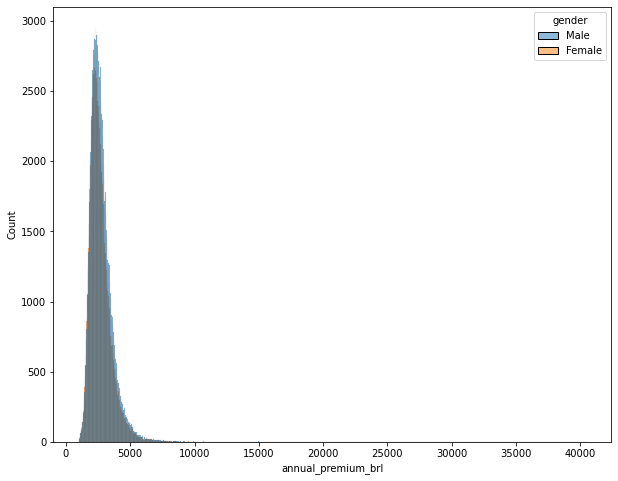

In [21]:
# annual_premium_brl
data_temp = data.loc[data['annual_premium_brl']>1000,['annual_premium_brl','gender']]

plt.figure(figsize=(10, 8))
sns.histplot(data = data_temp, x='annual_premium_brl', hue='gender')
plt.show()

- looks like there is no diference or its to small, lets test this hyphotesis

  H0 - There is no diference.
  
  H1 - THere  a diference. 
  
Oww the null hyphotesis was rejected.

In [24]:
sample_class0 = data.loc[data['gender']=='Male','annual_premium_brl']
sample_class1 = data.loc[data['gender']=='Female','annual_premium_brl']

print(f'The Mean to class Male: {np.mean(sample_class0)}')
print(f'The Mean to class Female: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class Male: 2293.6364192727415
The Mean to class Female: 2284.1345204468057


O valor de p é: 0.02336987591618305
Provável haver diferença


(2.2673423807234645, 0.02336987591618305)

## Is the annual_premium value diferent by age and the what about the interest?

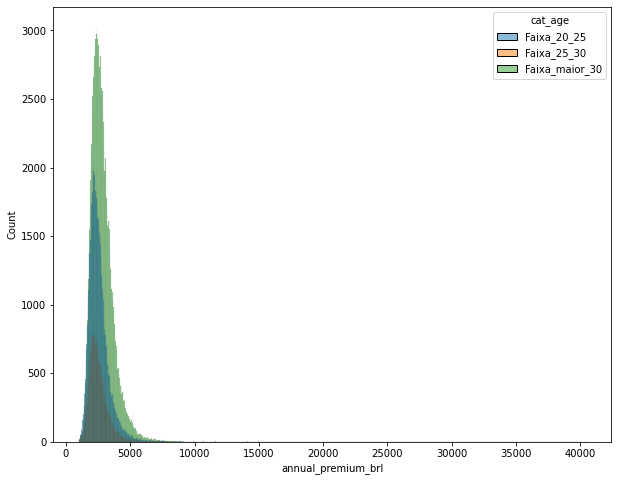

In [29]:
# annual_premium_brl
data_temp = data.loc[data['annual_premium_brl']>1000,['annual_premium_brl','cat_age']]

plt.figure(figsize=(10, 8))
sns.histplot(data = data_temp, x='annual_premium_brl', hue='cat_age')
plt.show()

- Lets test this hyphotesis

  H0 - There is no diference.
  
  H1 - There is  a diference. 

In [30]:
sample_class0 = data.loc[data['cat_age']=='Faixa_20_25','annual_premium_brl']
sample_class1 = data.loc[data['cat_age']=='Faixa_25_30','annual_premium_brl']
sample_class2 = data.loc[data['cat_age']=='Faixa_maior_30','annual_premium_brl']

print(f'The Mean to class Faixa_20_25: {np.mean(sample_class0)}')
print(f'The Mean to class Faixa_25_30: {np.mean(sample_class1)}')
print(f'The Mean to class Faixa_maior_30: {np.mean(sample_class2)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1, sample_class2)

The Mean to class Faixa_20_25: 2309.308415749079
The Mean to class Faixa_25_30: 2155.774125670841
The Mean to class Faixa_maior_30: 2307.4206651173185


O valor de p é: 1.5356609965083935e-125
Provável haver diferença


(287.6110102788534, 1.5356609965083935e-125)

- Probably there is a diference between the samples(very low p-value) the insurances to customers between 20 ans 25 are more expensive.

## Vehicle being damaged changes the annual_premium and the interest? 

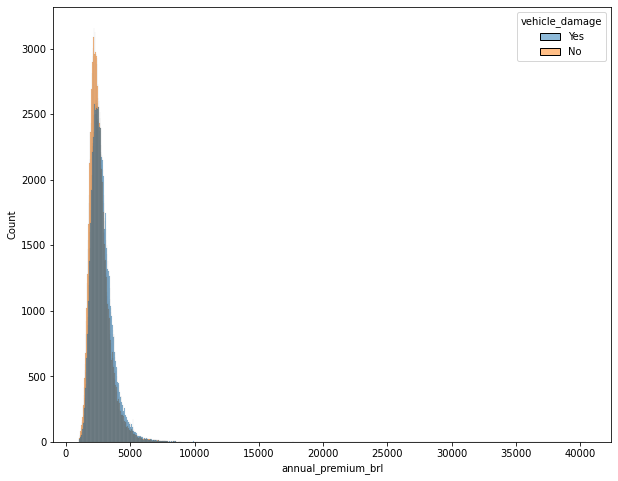

In [14]:
# annual_premium_brl
data_temp = data.loc[data['annual_premium_brl']>1000,['annual_premium_brl','vehicle_damage']]

plt.figure(figsize=(10, 8))
sns.histplot(data = data_temp, x='annual_premium_brl', hue='vehicle_damage')
plt.show()

- Lets test this hyphotesis

  H0 - There is no diference.
  
  H1 - There is  a diference. 

In [15]:
sample_class0 = data.loc[data['vehicle_damage']=='Yes','annual_premium_brl']
sample_class1 = data.loc[data['vehicle_damage']=='No','annual_premium_brl']

print(f'The Mean to class Yes: {np.mean(sample_class0)}')
print(f'The Mean to class No: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class Yes: 2301.2094870247847
The Mean to class No: 2277.100938828592


O valor de p é: 7.8428728621948e-09
Provável haver diferença


(5.771930875281247, 7.8428728621948e-09)

- Seems that if you have damaged your car you will pay more for your insurance.

## Is the annual_premium value diferente by vehicle_age and the interest?

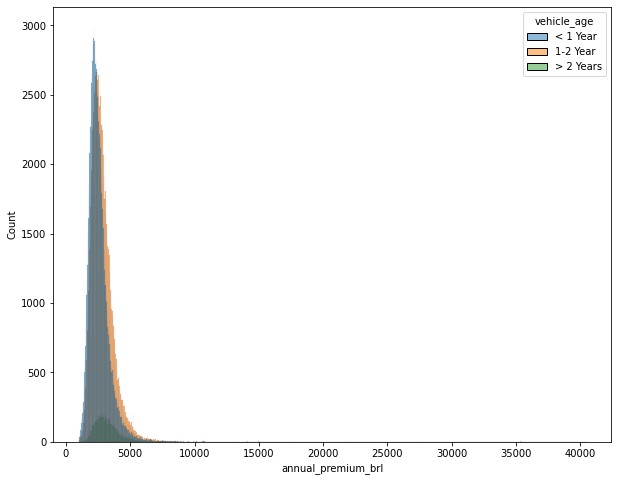

In [16]:
# annual_premium_brl
data_temp = data.loc[data['annual_premium_brl']>1000,['annual_premium_brl','vehicle_age']]

plt.figure(figsize=(10, 8))
sns.histplot(data = data_temp, x='annual_premium_brl', hue='vehicle_age')
plt.show()

- Lets test this hyphotesis

  H0 - There is no diference.
  
  H1 - There is  a diference. 

In [18]:
sample_class0 = data.loc[data['vehicle_age']=='< 1 Year','annual_premium_brl']
sample_class1 = data.loc[data['vehicle_age']=='1-2 Year','annual_premium_brl']
sample_class2 = data.loc[data['vehicle_age']=='> 2 Years','annual_premium_brl']

print(f'The Mean to class < 1 Year: {np.mean(sample_class0)}')
print(f'The Mean to class 1-2 Year: {np.mean(sample_class1)}')
print(f'The Mean to class > 2 Year: {np.mean(sample_class2)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1, sample_class2)

The Mean to class < 1 Year: 2255.9544466762954
The Mean to class 1-2 Year: 2286.2163008067255
The Mean to class > 2 Year: 2670.522010226776


O valor de p é: 0.0
Provável haver diferença


(758.4558361107572, 0.0)

- Seems that iif your car is new '< 1 Year' the insurance si cheaper.

# Data Preparation

## Split of Data

In [14]:
# test_data
test_data = data.sample(76221)
print(f'The Shape: {test_data.shape}')

# train_data
train_data = data[~data.id.isin(test_data.id)]
print(f'The Shape: {train_data.shape}')

The Shape: (76221, 17)
The Shape: (304888, 17)


In [15]:
# Spliting valid data
columns = train_data.columns.to_list()
columns.remove('response')

# X e y
X = train_data[columns]
y = train_data.response

# Splitting
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=.20, shuffle=True, random_state=0)

## Preparation

 - Drop id, annual_premium
 - Encoding categoricals
 - Standart scaler na var numericas
 - Robust scaler no annual_premium_brl

In [16]:
# Dropping id, annual_premium
Xtrain.drop(['id','annual_premium'], axis=1, inplace=True)
Xvalid.drop(['id','annual_premium'], axis=1, inplace=True)

In [17]:
# Encoding categoricals
categoricals = Xtrain.select_dtypes(include = ['object']).columns.to_list()

# Encoder
enc = OrdinalEncoder()

for cat in categoricals:
    Xtrain[cat] = enc.fit_transform(np.array(Xtrain[cat]).reshape(-1,1))
    Xvalid[cat] = enc.fit_transform(np.array(Xvalid[cat]).reshape(-1,1))

In [18]:
# Standart Scaler variaveis numericas
numericals = Xtrain.select_dtypes(include = ['int64', 'float64']).columns.to_list()
numericals.remove('annual_premium_brl')

# Scaler
scaler = StandardScaler()

# Encoding
for num in numericals:
    Xtrain[num] = scaler.fit_transform(np.array(Xtrain[num]).reshape(-1,1))
    Xvalid[num] = scaler.fit_transform(np.array(Xvalid[num]).reshape(-1,1))
    
# RobusScaler
var = 'annual_premium_brl'
rscaler = RobustScaler()

# Encoding
Xtrain[var] = rscaler.fit_transform(np.array(Xtrain[var]).reshape(-1,1))
Xvalid[var] = rscaler.fit_transform(np.array(Xvalid[var]).reshape(-1,1))

In [19]:
# Balancing the data
smt = SMOTETomek(sampling_strategy='minority' ,random_state=42)

Xtrain_smt, ytrain_smt = smt.fit_resample(Xtrain, ytrain)
Xvalid_smt, yvalid_smt = smt.fit_resample(Xvalid, yvalid)

In [20]:
# All Preparation Done
print(Xtrain_smt.shape)
Xtrain_smt.head()

(419008, 14)


,previously_insured,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,annual_premium_brl,annual_premium_brl_squared,annual_premium/vintage,cat_age,median_by_policy
0,1.087070,1.680253,0.921302,0.718965,1.104346,-1.583544,0.046222,-0.892545,-1.008300,-0.037360,-0.110859,-0.471024,0.780070,0.531004
1,1.087070,-0.386712,0.921302,0.202977,1.558275,0.222759,0.046222,-0.892545,-1.008300,-0.177558,-0.163362,-0.229998,0.780070,0.302957
2,-0.919904,-0.757093,0.921302,2.073434,0.120832,-1.583544,0.046222,-0.892545,0.991769,1.401516,0.640966,0.393401,0.780070,0.531004
3,1.087070,-0.852675,0.921302,-0.700002,0.045177,0.738846,0.046222,0.836322,-1.008300,-1.930200,-0.508743,-0.605459,-0.351864,-0.011946
4,-0.919904,-0.004383,-1.085420,0.460971,0.120832,-1.583544,0.046222,-0.892545,0.991769,1.347936,0.606013,-0.048393,0.780070,0.531004


In [21]:
print(Xvalid_smt.shape)
Xvalid_smt.head()

(104694, 14)


,previously_insured,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,annual_premium_brl,annual_premium_brl_squared,annual_premium/vintage,cat_age,median_by_policy
0,1.088525,0.795664,0.920497,-1.144780,0.202404,0.735841,0.047104,0.845343,-1.011447,0.704412,0.205894,-0.313910,-1.475011,-0.011226
1,1.088525,-0.712332,0.920497,-0.951418,0.277877,0.735841,0.047104,0.845343,-1.011447,-0.283762,-0.179943,-0.135181,-1.475011,-0.011226
2,1.088525,-0.724301,-1.086370,2.077917,0.126931,-1.593327,0.047104,-0.896003,-1.011447,0.444571,0.088579,0.082003,0.785806,0.530990
3,1.088525,-1.179093,-1.086370,-0.951418,-1.382531,0.735841,0.047104,0.845343,-1.011447,0.577909,0.147366,0.652431,-1.475011,-0.011226
4,-0.918674,-1.214998,0.920497,1.368923,0.126931,0.218248,0.047104,-0.896003,0.988683,0.715066,0.210946,0.797543,0.785806,0.303251


# Feature Selection

In [22]:
# Modelo
model = lgb.LGBMClassifier()

#Selecionador de Features
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=True, )

Feature_Selector.fit(X=Xtrain_smt,y=ytrain_smt, n_trials=10, random_state=1)

100%|██████████| 10/10 [02:57<00:00, 17.80s/it]

14 attributes confirmed important: ['annual_premium_brl', 'vehicle_age', 'cat_age', 'policy_sales_channel', 'median_by_policy', 'vehicle_damage', 'vintage', 'annual_premium_brl_squared', 'region_code', 'previously_insured', 'driving_license', 'age', 'gender', 'annual_premium/vintage']
0 attributes confirmed unimportant: []
0 tentative attributes remains: []


In [23]:
# Visualizando as variáveis selecioandas
X_subset = Feature_Selector.Subset()
X_subset.head()

,annual_premium_brl,vehicle_age,cat_age,policy_sales_channel,median_by_policy,vehicle_damage,vintage,annual_premium_brl_squared,region_code,previously_insured,driving_license,age,gender,annual_premium/vintage
0,-0.037360,-0.892545,0.780070,-1.583544,0.531004,-1.008300,1.680253,-0.110859,1.104346,1.087070,0.046222,0.718965,0.921302,-0.471024
1,-0.177558,-0.892545,0.780070,0.222759,0.302957,-1.008300,-0.386712,-0.163362,1.558275,1.087070,0.046222,0.202977,0.921302,-0.229998
2,1.401516,-0.892545,0.780070,-1.583544,0.531004,0.991769,-0.757093,0.640966,0.120832,-0.919904,0.046222,2.073434,0.921302,0.393401
3,-1.930200,0.836322,-0.351864,0.738846,-0.011946,-1.008300,-0.852675,-0.508743,0.045177,1.087070,0.046222,-0.700002,0.921302,-0.605459
4,1.347936,-0.892545,0.780070,-1.583544,0.531004,0.991769,-0.004383,0.606013,0.120832,-0.919904,0.046222,0.460971,-1.085420,-0.048393


# Machine Learning Models

## Model Selection with Pycaret

In [24]:
# pycaret setup - to test several models

# Train data
data_train = X_subset.copy()
data_train['target'] = ytrain_smt

# Sampling due memory problems
data_train = data_train.sample(200000)

# Test train

# Variable list selected by Boruta
colunas = X_subset.columns.to_list()
colunas.append('target')

# copy 
data_test = Xvalid_smt.copy()
data_test['target'] = yvalid_smt

# Filtering and Sampling due memory problems
data_test = data_test[colunas]
data_test = data_test.sample(75000)

setup = setup(data = data_train, 
              target='target', 
              train_size=.80, 
              test_data=data_test)

,Description,Value
0,session_id,3230
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(200000, 15)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [25]:
compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9059,0.9754,0.8757,0.9314,0.9027,0.8118,0.8132,20.2920
xgboost,Extreme Gradient Boosting,0.9009,0.9747,0.9008,0.9004,0.9006,0.8018,0.8018,7.7770
et,Extra Trees Classifier,0.8959,0.9704,0.9609,0.8499,0.9020,0.7920,0.7988,4.3470
rf,Random Forest Classifier,0.8933,0.9689,0.9462,0.8551,0.8984,0.7867,0.7911,6.2110
dt,Decision Tree Classifier,0.8850,0.8851,0.8922,0.8790,0.8855,0.7701,0.7702,0.3940
lightgbm,Light Gradient Boosting Machine,0.8836,0.9682,0.9084,0.8649,0.8861,0.7672,0.7682,0.5000
knn,K Neighbors Classifier,0.8484,0.9105,0.9555,0.7863,0.8627,0.6970,0.7136,1.5450
gbc,Gradient Boosting Classifier,0.8288,0.9140,0.9593,0.7600,0.8481,0.6578,0.6815,6.1610
ada,Ada Boost Classifier,0.8241,0.8847,0.9480,0.7591,0.8431,0.6485,0.6694,1.5250
nb,Naive Bayes,0.7970,0.8322,0.9427,0.7293,0.8224,0.5944,0.6214,0.0400


From all tested models CatBoostClassifier e ExtraTreesClassifier achieved the best balance between Recall and Precision

## Extra Trees Classifier

### ExtraTrees Cross Validation

In [26]:
%%time
# Data
X= data_train.drop('target', axis=1)
y= data_train['target']

# Evaluation with cross validation function
def cross_val_ExtraTree(X, y):

    model = ExtraTreesClassifier()

    # Dicionário de metricas
    resultados = {'ACC_MEAN': [],
                  'ACC_STD': [],
                  'RECALL_MEAN': [],
                  'RECALL_STD': [],
                  'F1_MEAN': [],
                  'F1_STD': [],
                  'PRECISION_MEAN': [],
                  'PRECISION_STD': []}

    # Accuracy
    Acc_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1))
    Acc_std = np.std(cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1))
    
    # Recall
    Recall_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='recall', n_jobs=-1))
    Recall_std = np.std(cross_val_score(model, X, y, cv=10, scoring='recall', n_jobs=-1))
    
    # F1-Score
    F1_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='f1', n_jobs=-1))
    F1_std = np.std(cross_val_score(model, X, y, cv=10, scoring='f1', n_jobs=-1))
    
    # Precision
    precision_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='precision', n_jobs=-1))
    precision_std = np.std(cross_val_score(model, X, y, cv=10, scoring='precision', n_jobs=-1))

    # Accuracy results
    resultados['ACC_MEAN'].append(Acc_mean)
    resultados['ACC_STD'].append(Acc_std)
    
    # Recall results
    resultados['RECALL_MEAN'].append(Recall_mean)
    resultados['RECALL_STD'].append(Recall_std)
    
    # F1 results
    resultados['F1_MEAN'].append(F1_mean)
    resultados['F1_STD'].append(F1_std)
    
    # Precision results
    resultados['PRECISION_MEAN'].append(precision_mean)
    resultados['PRECISION_STD'].append(precision_std)
    
    # Painel
    painel_df = pd.DataFrame(resultados).T
    painel_df.rename(columns={0:"ExtraTree Metrics"}, inplace=True)
    
    return painel_df, model


painel, ExtraTreeModel = cross_val_ExtraTree(X=X, y=y)
painel

CPU times: user 611 ms, sys: 611 ms, total: 1.22 s
Wall time: 5min


,ExtraTree Metrics
ACC_MEAN,0.895985
ACC_STD,0.002209
RECALL_MEAN,0.960815
RECALL_STD,0.001667
F1_MEAN,0.902242
F1_STD,0.001714
PRECISION_MEAN,0.849953
PRECISION_STD,0.003086


### Tunning the ExtraTrees

In [27]:
%%time
param_grid = {
              'n_estimators': [100, 500, 1000],
              'max_depth': [10, 31, 50],
              'min_samples_split' : [2, 5, 10]
             }

# Function to tune the parameters
def tunnig_gridsearch(Xtrain, model, param_grid, cv, scoring, refit):

    """
    Função para tunnig de parâmetros utilizando o GridSearchCV"""
    
    X_= Xtrain.drop('target', axis=1)
    y_= Xtrain['target']
    

    search = RandomizedSearchCV(estimator=model,
                            param_distributions=param_grid,
                            scoring=scoring,
                            refit=refit,
                            cv=cv,
                            verbose=1,
                            n_jobs=-1,
                            return_train_score=True)
    search.fit(X_, y_)

    return search.best_params_, search.cv_results_

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.5 µs


In [ ]:
%%time
# ExtraTreeModel
best_params, cv_results = tunnig_gridsearch(Xtrain=data_train, model=ExtraTreeModel, param_grid=param_grid, cv=10, scoring='recall', refit=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


### Evaluate the ExtraTrees Model

## CatBoost Classifier

### CatBosst Crossvalidation

In [58]:
%%time
# Evaluation with cross validation function
def cross_val_CatBoost(X, y):

    model = CatBoostClassifier()

    # Dicionário de metricas
    resultados = {'ACC_MEAN': [],
                  'ACC_STD': [],
                  'RECALL_MEAN': [],
                  'RECALL_STD': [],
                  'F1_MEAN': [],
                  'F1_STD': [],
                  'PRECISION_MEAN': [],
                  'PRECISION_STD': []}

    # Accuracy
    Acc_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1))
    Acc_std = np.std(cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1))
    
    # Recall
    Recall_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='recall', n_jobs=-1))
    Recall_std = np.std(cross_val_score(model, X, y, cv=10, scoring='recall', n_jobs=-1))
    
    # F1-Score
    F1_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='f1', n_jobs=-1))
    F1_std = np.std(cross_val_score(model, X, y, cv=10, scoring='f1', n_jobs=-1))
    
    # Precision
    precision_mean = np.mean(cross_val_score(model, X, y, cv=10, scoring='precision', n_jobs=-1))
    precision_std = np.std(cross_val_score(model, X, y, cv=10, scoring='precision', n_jobs=-1))

    # Accuracy results
    resultados['ACC_MEAN'].append(Acc_mean)
    resultados['ACC_STD'].append(Acc_std)
    
    # Recall results
    resultados['RECALL_MEAN'].append(Recall_mean)
    resultados['RECALL_STD'].append(Recall_std)
    
    # F1 results
    resultados['F1_MEAN'].append(F1_mean)
    resultados['F1_STD'].append(F1_std)
    
    # Precision results
    resultados['PRECISION_MEAN'].append(precision_mean)
    resultados['PRECISION_STD'].append(precision_std)
    
    # Painel
    painel_df = pd.DataFrame(resultados).T
    painel_df.rename(columns={0:"ExtraTree Metrics"}, inplace=True)
    
    return painel_df, model


painel, _ = cross_val_CatBoost(X=X, y=y)
painel

KeyboardInterrupt: 

### Tunnig the CatBoost

### Evaluate the CatBoost Model

## Calibração do Modelo